**# Importing all the necessary modules and loading data**

In [7]:
from collections import deque
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, cohen_kappa_score
from sklearn.decomposition import PCA

# Load the CIFAR-10 dataset
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

pca = PCA(n_components=100)  # Adjust the number of components to find a good balance between performance and computational burden

# Preprocessing: Flatten the labels
y_train = y_train.flatten()
y_test = y_test.flatten()


# **Feature Extraction**

In [8]:
# Scale the pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the image data to be used as state representations
x_train_features = x_train.reshape((x_train.shape[0], -1))
x_test_features = x_test.reshape((x_test.shape[0], -1))

from sklearn.decomposition import PCA

# Apply PCA to reduce the dimensionality of the feature space
pca = PCA(n_components=100)  # Adjust the number of components to find a good balance between performance and computational burden
x_train_features = pca.fit_transform(x_train_features)
x_test_features = pca.transform(x_test_features)


# **Defining our custom environment class**

In [9]:
import gym
from gym import spaces

class CIFAR10Env(gym.Env):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels
        self.current_index = 0

        self.action_space = spaces.Discrete(10)
        self.observation_space = spaces.Box(low=0, high=255, shape=(data.shape[1],), dtype=float)

    def step(self, action):
        reward = 1 if action == self.labels[self.current_index] else -1
        self.current_index += 1
        done = self.current_index >= len(self.data)
        info = {}
        next_state = self.data[self.current_index] if not done else None
        return next_state, reward, done, info

    def reset(self):
        self.current_index = (self.current_index + 1) % len(self.data)
        return self.data[self.current_index]


# **Define the DNQ Agent class**

In [10]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)  # Limiting the size of replay memory
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(16, input_dim=self.state_size, activation='relu'))  # Reduced the number of neurons
        model.add(Dense(16, activation='relu'))  # Reduced the number of neurons
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # ... (keep the other methods unchanged)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def train_model(self, batch_size=24):  # Reduced the batch size to save memory
        mini_batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# **Training Loop**

In [11]:
# Main script to initialize the environment and agent and run the training loop

# Initialize environment and agent
env = CIFAR10Env(data=x_train_features, labels=y_train)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

# Training loop
EPISODES = 500
batch_size = 16

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(300):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size]) if next_state is not None else None
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"episode: {e}/{EPISODES}, score: {time}, e: {agent.epsilon:.2}")
            break
    if len(agent.memory) > batch_size:
        agent.train_model(batch_size)


1/1 [==============================] - 0s 19ms/step
episode: 166/500, score: 32, e: 0.44
1/1 [==============================] - 0s 16ms/step
episode: 333/500, score: 32, e: 0.19
1/1 [==============================] - 0s 29ms/step


# **Evaluation**

In [12]:
# Class names for the CIFAR-10 dataset
class_names = [
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
]

# Evaluation loop
all_true_labels = []
all_predicted_labels = []

# Disable exploration
agent.epsilon = 0


# **Evaluation Loop**

In [13]:
for i in range(len(x_test_features)):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    action = agent.act(state)
    all_true_labels.append(y_test[i])
    all_predicted_labels.append(action)


1/1 [==============================] - 0s 31ms/step


# **Performance Matrix**

In [14]:
# Compute performance metrics
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
# roc_auc = roc_auc_score(y_test, agent.model.predict(x_test_features), multi_class='ovr')
classification_rep = classification_report(all_true_labels, all_predicted_labels, target_names=class_names)
kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\\n{conf_matrix}")
# print(f"ROC AUC Score:\\n{roc_auc}")
print(f"Classification Report:\\n{classification_rep}")
print(f"Cohen's Kappa: {kappa}")


Accuracy: 0.0978
Confusion Matrix:\n[[537  28 159   4   3  61   1   0   0 207]
 [540  27 161   3   6  51   0   0   0 212]
 [545  24 169   5   8  57   0   0   0 192]
 [538  36 137   2   8  69   0   0   0 210]
 [524  24 164   6   3  69   0   0   1 209]
 [555  22 144   5  13  58   0   0   0 203]
 [547  33 169   4   3  59   0   0   0 185]
 [560  29 159   5   6  54   0   0   0 187]
 [536  28 166   4   2  54   1   0   0 209]
 [561  31 154   1  11  60   0   0   0 182]]
Classification Report:\n              precision    recall  f1-score   support

    airplane       0.10      0.54      0.17      1000
  automobile       0.10      0.03      0.04      1000
        bird       0.11      0.17      0.13      1000
         cat       0.05      0.00      0.00      1000
        deer       0.05      0.00      0.01      1000
         dog       0.10      0.06      0.07      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.0

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Confusion Matrix**

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix


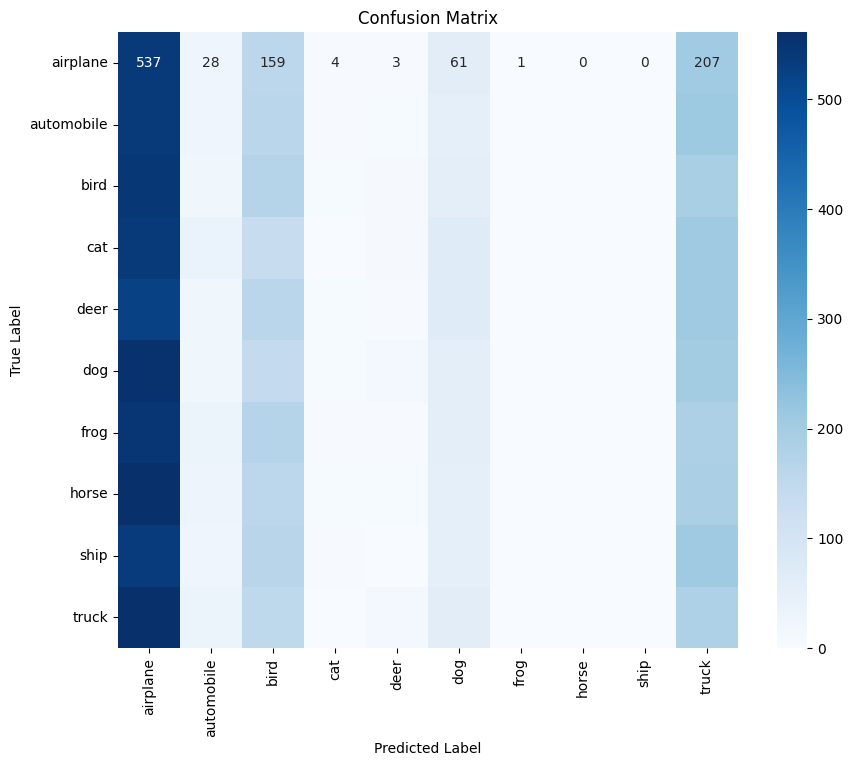

In [16]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# **ROC_Curves**

313/313 [==============================] - 0s 613us/step


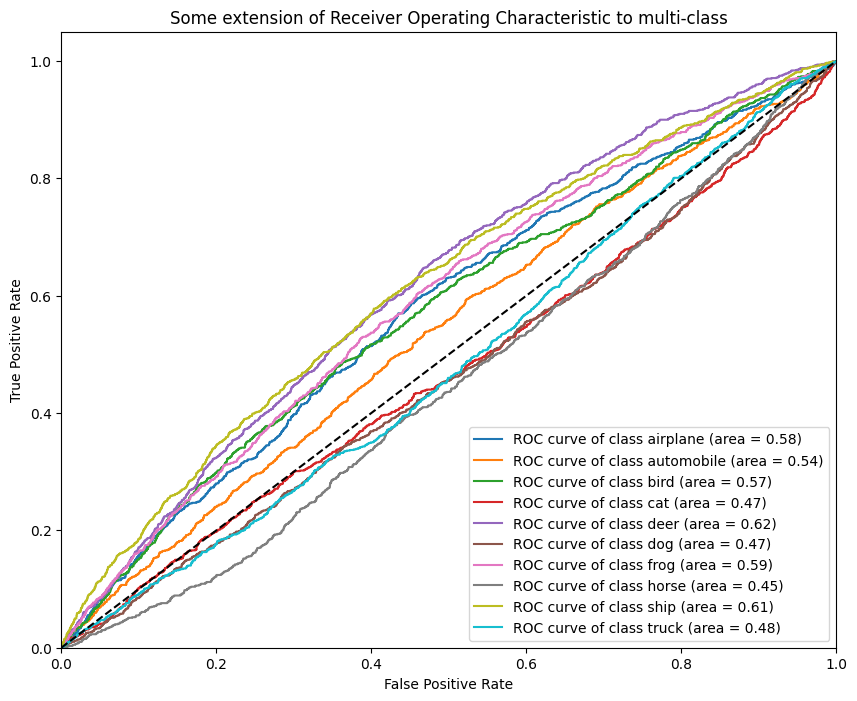

In [17]:
# Binarize the labels
binarized_labels = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Get the predictions
y_score = agent.model.predict(x_test_features)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):  # assuming 10 classes
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
